<div style="background-color:rgba(20, 20, 20, 0.8); color:white; padding:10pt" >    

# **TP Introduction au traitement d'images**
&mdash; **`alain.lebret@ensicaen.fr`** &mdash;

### Partie 5 : segmentation


### 5.1. Introduction à la segmentation d'image

La segmentation d'image est un processus clé en traitement d'image qui vise à identifier et à isoler différentes entités (telles que des régions ou des objets) dans une image selon des critères d'homogénéité. Prenons l'exemple des jetons de vote : ils possèdent une couleur distincte par rapport à la feuille de papier sur laquelle ils reposent et par rapport au fond. Segmenter ces jetons en les distinguant de la feuille de papier constitue une application typique de la segmentation d'image.

Il existe deux principales approches en segmentation d'image :

- Approche basée sur les **contours** : Cette méthode se concentre sur la détection des changements brusques d'intensité dans l'image, qui correspondent souvent aux bords des objets. Elle utilise des opérateurs différentiels, comme l'opérateur gradient, pour identifier ces bords. L'objectif est de tracer les contours des objets, en mettant en évidence les limites entre différentes régions.

- Approche basée sur les **régions** : Contrairement à l'approche par contours, l'approche par régions cherche à regrouper les pixels similaires en fonction de critères spécifiques tels que la couleur, l'intensité ou la texture. Cette méthode vise à identifier et à isoler des régions homogènes dans l'image, ce qui est utile pour comprendre la composition globale de la scène.

Chacune de ces approches a ses avantages et ses applications spécifiques, et le choix entre elles dépend des caractéristiques de l'image et des objectifs de la segmentation.

### 5.2. Chargement des dépendances

In [4]:
#!pip3 install scikit-learn

#
# Loads required libraries 
#
import math
import numpy as np
import skimage              # scikit-image
from skimage import data    # some images to use
from skimage import io      # open, write, etc. image files
from skimage import color   # conversion between color spaces 
from skimage import filters # threshold_mean, threshold_otsu 
from skimage import util    # random_noise
from skimage import feature # Canny filter 
from skimage import measure # Measures on objects 
from skimage import morphology # to use morphology
from matplotlib import pyplot as plt
#from sklearn import cluster # KMeans

#
# Uncomments the lines below if using Google Colab
#
#from google.colab import drive
#from google.colab.patches import cv2_imshow

In [20]:
root_path = '../ressources'
smaller = root_path + '/256x256'
medium = root_path + '/512x512'
various = root_path + '/divers'

### 5.3. Extraction d'objets
#### 5.3.1. Seuillage

Le seuillage est une technique fondamentale en traitement d'image, particulièrement utilisée pour simplifier l'analyse d'une image en niveaux de gris en la convertissant en une image binaire (noir et blanc). Cette méthode repose sur la définition d'un seuil de luminosité :

- Pixels inférieurs au seuil : Tout pixel dont l'intensité est inférieure à ce seuil est converti en noir (valeur 0).
- Pixels supérieurs ou égaux au seuil : Les pixels dont l'intensité est supérieure ou égale au seuil sont convertis en blanc (valeur 1).

Cette binarisation facilite l'identification et l'extraction d'objets dans l'image, en particulier lorsque l'on cherche à séparer des éléments d'intérêt d'un fond uniforme ou lors de la segmentation des images en différentes composantes basées sur leur intensité.

Le choix du seuil est crucial et peut varier en fonction des caractéristiques de l'image et des objectifs de la segmentation. Il existe plusieurs méthodes pour déterminer un seuil adéquat, des approches manuelles aux méthodes automatiques basées sur les statistiques de l'image.

<div style="background-color:rgba(255, 183, 77, 0.8); padding:5pt" >    

---

#### Manipulation n° 5.1 : exploration des méthodes de seuillage

##### 1. Seuillage manuel basé sur l'Histogramme :

- Commencez par analyser l'histogramme de l'image "circuit_512x512.jpg" pour choisir un seuil approprié. L'histogramme vous aidera à identifier les distributions d'intensité dans l'image et à sélectionner un seuil pour la binarisation.
- Réalisez le seuillage de l'image en utilisant le seuil choisi : `image_seuillee = image > seuil`.
- Affichez l'image originale et l'image seuillée côte à côte pour comparer les effets du seuillage.

##### 2. Seuillage automatique avec la moyenne des intensités :

- Utilisez la fonction [`threshold_mean()`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_mean) du module `filters` de *Scikit-image*. Cette méthode calcule automatiquement un seuil basé sur la moyenne des intensités de l'image.
- Appliquez ce seuil à l'image et affichez le résultat.

##### 3. Seuillage avec la méthode d'Otsu :

- Utilisez la fonction [`threshold_otsu()`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_otsu) également du module `filters` de *Scikit-image*. La méthode d'Otsu détermine un seuil optimal en analysant la forme de l'histogramme de l'image.
- Réalisez le seuillage avec ce seuil et affichez l'image obtenue.

##### 4. Comparaison des résultats :

- Comparez les trois images seuillées pour évaluer l'efficacité de chaque méthode de seuillage. Prenez en compte la clarté des bords, la séparation des objets d'intérêt et la suppression du bruit de fond.

---
    
</div>

45.390113830566406
45.390113830566406
86


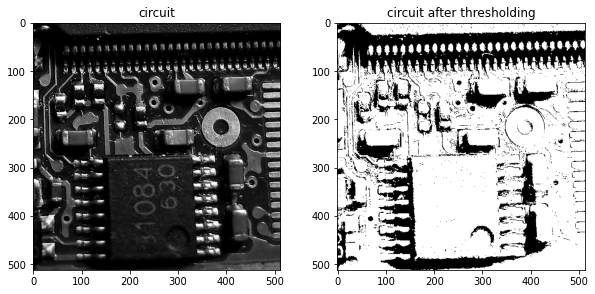

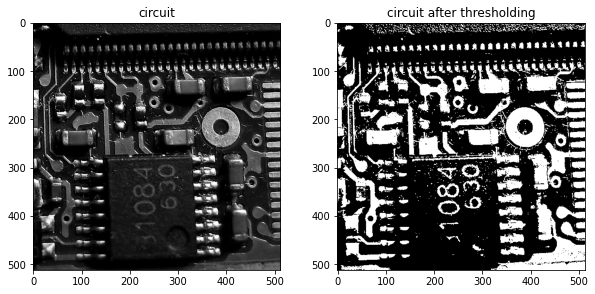

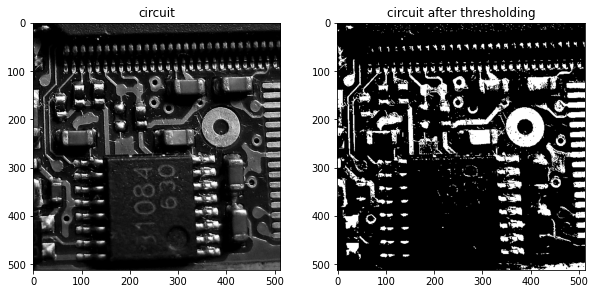

In [4]:
#
# Mettez votre code ici
#


#### 5.3.2. Détection de contours

La détection de contours est une étape essentielle en traitement d'image, permettant d'identifier les bords significatifs dans une scène. Parmi les diverses techniques disponibles, le filtre de Canny est particulièrement reconnu pour son efficacité. Ce filtre développé par John F. Canny en 1986, est une méthode multi-étapes qui vise à identifier les bords avec une grande précision. Il implique plusieurs étapes clés :

1. Réduction du bruit : L'image est d'abord lissée avec un filtre gaussien pour atténuer le bruit, ce qui aide à éviter la détection de faux bords.
2. Calcul du gradient : Le filtre détecte les bords en cherchant les maxima locaux du gradient de l'image. Cela se fait généralement en utilisant les opérateurs de Sobel pour calculer les composantes horizontales et verticales du gradient.
3. Suppression des non-maxima : Cette étape affine les bords potentiels pour s'assurer qu'ils sont nets et bien définis.
4. Seuillage avec hystérésis : Deux seuils sont définis, un bas et un haut. Les bords forts (au-dessus du seuil haut) sont conservés tandis que les bords faibles (au-dessous du seuil bas) sont supprimés. Les bords faibles qui sont connectés aux bords forts sont également conservés, ce qui permet de préserver les structures importantes de l'image.

<div style="background-color:rgba(255, 183, 77, 0.8); padding:5pt" >    

---

#### Manipulation n° 5.2 : Application du filtre de Canny

##### 1. Filtre de Canny sur l'image des jetons de vote :

- Commencez par appliquer le filtre de Canny à l'image "jetons_vote.jpg", qui représente des jetons de vote de l'époque romaine. Utilisez pour cela la fonction [`canny()`](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny) du module `feature` de *Scikit-image*.
- Observez les contours détectés et évaluez leur précision pour identifier et extraire les jetons de vote dans l'image.

##### 2. Influence du pré-filtrage gaussien :

- Expérimentez avec différentes valeurs de paramètres pour le pré-filtrage gaussien intégré au filtre de Canny. Cette étape lisse l'image pour réduire le bruit et améliorer la détection des contours.
- Évaluez comment le choix des paramètres du filtre gaussien influence la qualité des contours détectés. Les résultats obtenus sont-ils suffisamment précis et pertinents pour une extraction efficace des jetons de vote ?

##### 3. Application sur une autre image :

- Répétez le processus sur une seconde image : "monnaies.png".
- Comparez les résultats obtenus avec ceux de la première image. Analysez l'efficacité du filtre de Canny dans des contextes variés et la capacité de l'algorithme à s'adapter à différentes caractéristiques d'image.

---
    
</div>

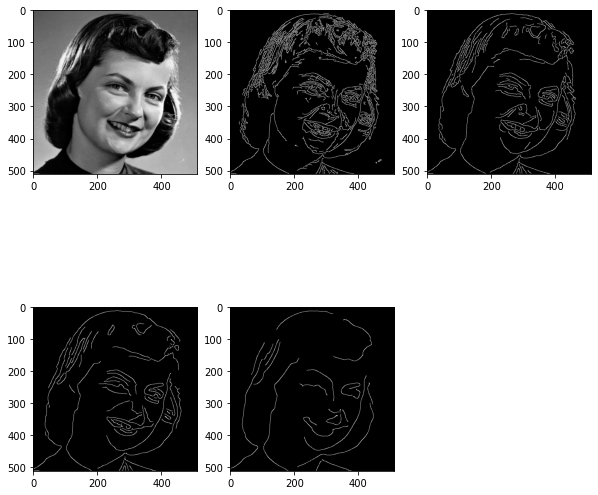

In [9]:
#
# Mettez votre code ici
#


#### 5.3.3. Segmentation par classification avec les k-Moyennes

Dans l'approche de segmentation basée sur les régions, l'objectif est de regrouper les pixels en classes homogènes, en affectant chaque pixel à la classe à laquelle il se rapporte le plus étroitement. Pour cela, les algorithmes de classification tels que les k-moyennes sont particulièrement adaptés.

La méthode des k-moyennes, disponible dans le module "`cluster`" de la bibliothèque *Scikit-learn* (sklearn), est un choix courant pour ce type de tâche. Bien qu'une compréhension détaillée de ses principes théoriques ne soit pas essentielle, il est important de savoir comment l'appliquer efficacement (cf. https://fr.wikipedia.org/wiki/K-moyennes).

Voici comment utiliser la fonction [`KMeans()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) pour segmenter une image en niveaux de gris en deux clusters :

```python
from skimage import io
from sklearn import cluster
import matplotlib.pyplot as plt

# Chargement de l'image
image = io.imread(medium + '/girlface.png')

# Transformation de l'image en un tableau 2D pour le clustering
# Utilisez number_of_channels = 3 pour des images RGB
number_of_channels = 1
image_2d = image.reshape(-1, number_of_channels)

# Application des k-moyennes avec 2 clusters
kmeans_cluster = cluster.KMeans(n_clusters=2)
kmeans_cluster.fit(image_2d)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

# Reconstruction de l'image segmentée
segmented_image = cluster_centers[cluster_labels].reshape(image.shape)

# Affichage de l'image originale et de l'image segmentée
figure = plt.figure(figsize=(10, 5))
figure.add_subplot(1, 2, 1)
plt.imshow(image, cmap='gray'), plt.title('Image Originale')
figure.add_subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='magma'), plt.title('Image Segmentée par k-Moyennes')
```

<div style="background-color:rgba(255, 183, 77, 0.8); padding:5pt" >    

---

#### **Manipulation n° 5.3 : Segmentation par k-Moyennes de l'Image des Jetons

##### 1. Analyse visuelle des classes :

- Commencez par examiner visuellement l'image des jetons de vote pour déterminer le nombre approximatif de classes (régions homogènes) qu'elle semble contenir.
- Estimez le nombre de groupes distincts en fonction des différences de couleur ou de texture.

##### 2. Application des k-Moyennes :

- Utilisez la fonction [`KMeans()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) du module `cluster` de *Scikit-learn* avec le nombre de classes identifié précédemment. Ce processus segmentera l'image en différentes régions en fonction de leurs caractéristiques.

##### 3. Impact de l'espace couleur :

- Expérimentez avec différents espaces couleur (tels que RVB, HSL) pour la segmentation.
- Observez comment le choix de l'espace couleur influence le résultat de la segmentation.

##### 4. Visualisation et analyse de la segmentation :

- Visualisez l'image segmentée (l'image des étiquettes de classe) et analysez les résultats. Sont-ils cohérents avec vos observations initiales ? Les régions sont-elles bien définies ?

##### 5. Identification des jetons :

- Déterminez quelle étiquette de classe correspond aux jetons de vote. Extrayez cette classe spécifique et commentez les résultats. Sont-ils précis et fidèles à la réalité de l'image ?

##### 6. Création d'une carte de composantes connexes :

- Re-étiquetez l'image segmentée pour obtenir une carte des "composantes connexes" (**régions**) pour les jetons. Cela implique de créer une image binaire où les jetons sont représentés en blanc sur un fond noir. Utilisez un seuillage approprié pour atteindre cet objectif.
    
---
    
</div>
  

In [1]:
#
# Mettez votre code ici
#


NameError: name 'io' is not defined

#### 5.3.4. Morphologie mathématique ensembliste pour la simplification d'image

Après la segmentation par classification, l'image obtenue de la classe des jetons de vote est essentiellement binaire, avec des valeurs de 1 pour les objets (les jetons) et de 0 pour le fond. Cependant, cette image peut aussi inclure des objets parasites ou du bruit, qui ne correspondent pas aux jetons et doivent être éliminés pour une analyse précise.

Cette étape de nettoyage et de simplification de l'image est cruciale avant de procéder au comptage et à la caractérisation des jetons. Pour cela, nous pouvons efficacement utiliser les techniques de la morphologie mathématique ensembliste. Ces techniques, basées sur des opérations ensemblistes appliquées à la forme et à la structure des objets dans l'image, permettent de traiter des images binaires de manière à simplifier leur contenu tout en préservant les caractéristiques essentielles.

Les opérations courantes de la morphologie mathématique incluent :

- L'**érosion** : Elle réduit les objets et élimine les petites irrégularités.
- La **dilatation** : Elle agrandit les objets et comble les petits trous et ruptures.
- L'**ouverture** : Elle est utile pour supprimer les petits objets et le bruit.
- La **fermeture** : Elle aide à combler les petits trous et les ruptures dans les objets.

Dans notre cas, nous utiliserons ces opérations pour affiner l'image des jetons, en supprimant les éléments indésirables et en améliorant la cohérence des régions représentant les jetons. Ces opérations sont fournies dans le module [`morphology`](https://scikit-image.org/docs/stable/api/skimage.morphology.html) de *Scikit-image*.

<div style="background-color:rgba(255, 183, 77, 0.8); padding:5pt" >    

---

#### Manipulation n° 5.4 : Nettoyage et affinage de l'image segmentée

##### 1. Suppression des objets parasites de petite taille :

- Utilisez des opérations morphologiques appropriées pour enlever les petits objets parasites de l'image segmentée. Des opérations telles que l'érosion suivie d'une dilatation (ouverture) peuvent être efficaces pour éliminer ces éléments indésirables sans altérer significativement les objets plus grands.

##### 2. Élimination des objets indésirables de taille comparable aux jetons :

Il est possible que l'image contienne des objets indésirables de taille similaire aux jetons, notamment ceux qui touchent les bords de l'image. Pour les supprimer, explorez l'utilisation de divers opérateurs morphologiques disponibles dans le module `morphology` de Scikit-image. Des techniques comme la soustraction des objets touchant les bords ou l'application d'une fermeture peuvent être utiles.

##### 3. Traitement des composantes connexes avec trous :

- Examinez les composantes connexes (les régions qui devraient correspondre aux jetons) et vérifiez si elles contiennent des trous ou des irrégularités. Si tel est le cas, utilisez des opérations morphologiques telles que la fermeture pour les combler et uniformiser ces régions.

##### 4. Visualisation et analyse finale :

- Après avoir appliqué ces traitements, visualisez l'image résultante. Les régions restantes doivent principalement correspondre aux jetons de vote.
- Analysez la clarté et la précision des régions extraites pour évaluer l'efficacité de vos méthodes de nettoyage.

---
    
</div>

In [1]:
#
# Mettez votre code ici
#


<div style="background-color:rgba(255, 183, 77, 0.8); padding:5pt" >    

---

#### **Manipulation n° 5.5 : Comptage et caractérisation des objets

Après avoir segmenté et nettoyé l'image dans les manipulations précédentes, il reste à aborder les défis suivants :

##### 1. Identification des problèmes avec certaines régions :

- Examinez les régions extraites de l'image nettoyée et identifiez les problèmes potentiels. Les défis courants incluent des régions fusionnées, des objets fragmentés, ou des artefacts qui ne correspondent pas aux jetons de vote.

##### 2. Étiquetage et comptage des objets :

- Utilisez la fonction [`label()`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label) du module `measure` de *Scikit-image* pour étiqueter chaque objet distinct dans l'image. Cela vous permettra de compter automatiquement le nombre de jetons de vote. Si le nombre d'objets détecté ne correspond pas à ce que vous attendiez, vous devrez peut-être revoir l'étape de nettoyage de l'image pour éliminer les erreurs de segmentation.

##### 3. Caractérisation des objets :

- Après avoir correctement étiqueté les objets, utilisez la fonction [`regionprops()`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops) pour obtenir des informations sur chaque jeton. Cette fonction fournit diverses caractéristiques telles que la surface, la sphéricité, et d'autres propriétés morphologiques.
- Affichez ces caractéristiques pour chaque jeton détecté afin d'obtenir une compréhension détaillée de leurs propriétés physiques.

##### 4. Visualisation et analyse :

- Visualisez les objets étiquetés pour confirmer visuellement leur précision. Comparez les caractéristiques extraites avec l'apparence visuelle des jetons dans l'image originale.

---
    
</div>

In [ ]:
#
# Mettez votre code ici
#


### Extraction des rondelles

Cette section se concentre sur l'application des techniques de traitement d'image que nous avons explorées précédemment, spécifiquement sur l'image "rondelles.bmp". Notre objectif est d'extraire efficacement les rondelles de l'image en appliquant une série d'étapes de prétraitement et de segmentation.

#### 5.4.1. Prétraitements de l'image

Le prétraitement est une étape essentielle pour préparer l'image pour une segmentation efficace. Les étapes de prétraitement pour l'image des rondelles pourraient inclure :

- Conversion en niveaux de gris : Si l'image est en couleur, commencez par la convertir en niveaux de gris pour simplifier l'analyse.
- Réduction du bruit : Appliquez des filtres, tels que le filtre gaussien, pour atténuer le bruit dans l'image. Cela aidera à éviter la détection de faux contours ou régions lors de la segmentation.
- Amélioration du contraste : Utilisez des techniques d'amélioration du contraste comme l'ajustement de l'histogramme pour rendre les rondelles plus distinctes par rapport au fond.
- Binarisation : En fonction de l'image, un seuillage peut être nécessaire pour convertir l'image en une forme binaire, facilitant la distinction entre les rondelles et le fond.
- Application de la morphologie mathématique : Selon les caractéristiques de l'image, des opérations morphologiques telles que l'érosion, la dilatation, l'ouverture ou la fermeture peuvent être utilisées pour affiner davantage l'image avant la segmentation.

<div style="background-color:rgba(255, 183, 77, 0.8); padding:5pt" >    

---

#### **Manipulation n° 5.6 : Prétraitement de l'image des rondelles

##### 1. Visualisation et rognage de l'image :

- Commencez par visualiser l'image des rondelles pour vous familiariser avec son contenu. Comme notre intérêt se concentre sur le centre de l'image où les rondelles sont posées sur une plaque de bois, nous allons rogner l'image pour ne garder que cette partie centrale.
- Utilisez une fonction appropriée de la bibliothèque *Scikit-image* pour rogner l'image. Par exemple, `skimage.util.crop()` peut être utilisée pour cet objectif. Toutes les manipulations ultérieures seront effectuées sur cette version rognée de l'image.

##### 2. Extraction et visualisation des composantes RVB :

- Séparez l'image couleur en ses trois composantes RVB (Rouge, Vert, Bleu) et visualisez-les individuellement. Cela vous aidera à comprendre comment les différentes composantes représentent les rondelles.

##### 3. Conversion en espace de couleur optimal :

- Évaluez si une conversion de l'espace couleur RVB vers un autre espace (comme HSV ou LAB) pourrait être plus avantageuse pour l'extraction des rondelles. Chaque espace couleur présente les données de manière différente, ce qui peut être utile pour certaines tâches de segmentation.
- Une fois que vous avez identifié l'espace de couleur le plus adapté, convertissez l'image et extrayez le canal (ou la composante) qui met le mieux en évidence les rondelles. Par exemple, dans l'espace HSV, le canal de saturation ou de valeur pourrait être plus utile pour distinguer les rondelles de l'arrière-plan.

##### 4. Visualisation du canal sélectionné :

- Affichez l'image résultante après la conversion et l'extraction du canal. Analysez visuellement si ce canal fournit une meilleure distinction des rondelles par rapport à l'image originale en RVB.

---
</div>

#### 5.4.2. Extraction et comptage de rondelles

<div style="background-color:rgba(255, 183, 77, 0.8); padding:5pt" >    

---

#### Manipulation n° 5.7 : Extraction et comptage des rondelles

##### 1. Extraction des rondelles :

- En utilisant les méthodes et techniques abordées précédemment, tentez d'extraire les rondelles de l'image. Appliquez les approches de segmentation, de classification ou de morphologie mathématique qui semblent les plus appropriées pour isoler les rondelles de leur environnement.

##### 2. Comptage des rondelles :

- Une fois les rondelles correctement extraites, procédez au comptage. Utilisez des techniques telles que l'étiquetage des composantes connexes et analysez les résultats obtenus.

##### 3. Défis spécifiques aux rondelles :

- Réfléchissez aux difficultés supplémentaires que pose l'extraction des rondelles. Cela pourrait inclure des problèmes tels que la superposition des rondelles, des variations de luminosité ou de couleur, ou des interférences avec le fond ou d'autres objets.

##### 4. Réflexion sur le lien entre acquisition et traitement d'images :

En se basant sur cette expérience, tirez des conclusions générales sur l'importance de la qualité de l'acquisition des images pour le traitement d'images efficace. 

---
    
</div>

In [5]:
#
# Mettez votre code ici
#
